En este notebook implementamos los modelos

In [ ]:
from sklearn.metrics import *
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.init as init
import importlib
import data
import agente
import torch
import torch.nn as nn
import torch.nn.functional as F
from itertools import islice
importlib.reload(data)
importlib.reload(agente)
import agente_knn
from torch.utils.data import Subset
import agente_mlp

In [3]:

path = "C:\\Users\\Itziar\\Documents\\Documentos\\PAD\\UTKFace"

# Transformar dataset 
Transformamos las imagenes en una estructura de datos con la que podamos trabajar

In [45]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) #Esto normalizara las imagenes
dataset = data.ImgDataset(path,transform=transform) #Pasamos las imagenes a la estructura de datos


In [46]:
# Crear los DataLoaders
train_dataloader,test_dataloader = data.entrenamientoTest(dataset=dataset,test_size=0.2,batch_size=4)

print(len(train_dataloader))
print(len(test_dataloader))

4741
1186


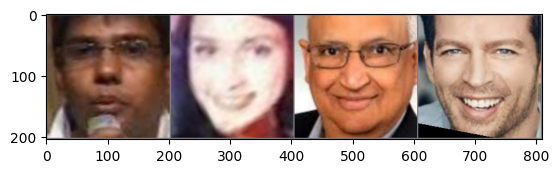

Edad:    24.0  28.0  62.0  26.0
Genero: Hombre Mujer Hombre Hombre
Raza:   Indio Blanco Indio Blanco


In [20]:
# Display image and label.
imagenes, edades,generos,razas = next(iter(train_dataloader))

# show images
data.mostrarImg(imagenes)
print('Edad:  ',' '.join('%5s' % edades[j].item() for j in range(4)))
print('Genero:',' '.join('%5s' % GENERO[generos[j].item()] for j in range(4)))
print('Raza:  ',' '.join('%5s' % RAZA[razas[j].item()] for j in range(4)))


In [7]:
def graficaEntrenamiento(train_loss,train_accuracy,test_loss,test_accuracy,epochs,nombre):
    x1 = np.arange(0,epochs)
    x2 = np.arange(0,epochs+1,5)

    
    fig,axs = plt.subplots(1,2)

    #Loss
    axs[0].plot(x1,train_loss,label = "Train Loss", color = 'b')
    axs[0].plot(x1,test_loss,label = "Test Loss", color = 'r')
    axs[0].set_title('Loss')  # Título del primer gráfico
    axs[0].set_xlabel('Epochs')  # Etiqueta del eje X
    axs[0].set_ylabel('Loss')  # Etiqueta del eje Y
    axs[0].legend()
    axs[0].grid(True)

    #Train
    axs[1].plot(x1,train_accuracy,label = "Train Accuracy", color = 'b')
    axs[1].plot(x1,test_accuracy,label = "Test Accuracy", color = 'r')
    axs[1].set_title('Accuracy')  # Título del primer gráfico
    axs[1].set_xlabel('Epochs')  # Etiqueta del eje X
    axs[1].set_ylabel('Acurracy')  # Etiqueta del eje Y
    axs[1].legend()
    axs[1].grid(True)
    
    plt.grid(True)
    plt.tight_layout()  # Ajusta el espaciado entre los subgráficos
    plt.savefig(f'.//Graficas//{nombre}')


# Modelo 1: Denzel Washington

Entrenaremos 3 modelos distintos, uno por cada objetivo que queremos predecir. 

Ambos modelos tendrán la misma estructura excepto en la ultima capa. 

Además el entrenamiento será distinto para cada uno de ellos pues utilizaremos distintos criterios y optimizadores segun el objetivo

In [22]:
class DenzelWashington(nn.Module):
    def __init__(self,output_layers):
        super().__init__()

        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 12, 5)
        self.pool2 = nn.MaxPool2d(4, 4)
       
        self.fc1 = nn.Linear(12 * 11 * 11, 500)
        self.fcout = nn.Linear(500, output_layers)

        self.apply(self._init_weights)  # Aplicar la inicialización de pesos

    def _init_weights(self, m):
        """Inicializa los pesos de la red"""
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            init.normal_(m.weight, mean=0.0, std=0.02)
            if m.bias is not None:
                init.constant_(m.bias, 0)

    def forward(self, x):

        x = self.pool1(x) #3 fotos 100x100
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = self.fcout(x)
        return x




In [23]:
#Esto sirve para ver en que dispositivo se entrena.
#GPU(cuda) es mas rapido que CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Entrenando en: {device}")

Entrenando en: cpu


Creamos un agente con los 3 modelos siguientes:

In [24]:
#Modelo edad
DWEdad = DenzelWashington(output_layers=1).to(device)
mseLoss = nn.MSELoss()

#Modelo Genero
DWGenero = DenzelWashington(output_layers=2).to(device)
entropyLossGen = nn.CrossEntropyLoss()

#Modelo raza
DWRaza = DenzelWashington(output_layers=5).to(device)
entropyLossRaza = nn.CrossEntropyLoss()

agenteDW = agente.Agente(modeloEdad=DWEdad,
                         modeloGenero=DWGenero,
                         modeloRaza=DWRaza,
                         criterioEdad=mseLoss,
                         criterioGenero=entropyLossGen,
                         criterioRaza=entropyLossRaza,
                         device=device,
                         lr = 0.0001)


- Genero : 20 epochs

In [25]:
train_loss_Genero,train_accuracy_Genero,test_loss_Genero,test_accuracy_Genero = agenteDW.entrenarModelo(train_dataloader,test_dataloader,"Genero",num_epochs=20)
#17 mins

KeyboardInterrupt: 

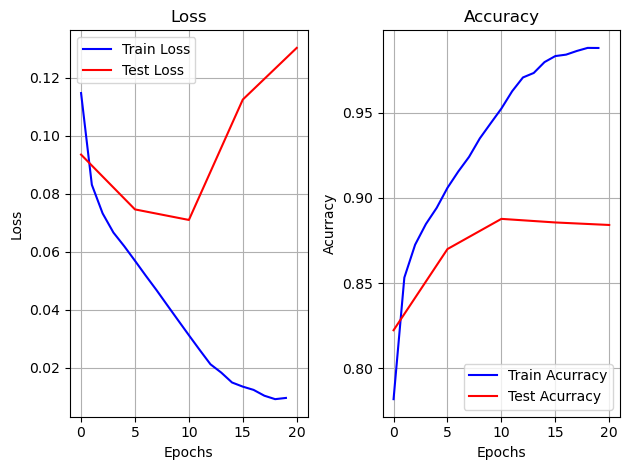

In [ ]:
np.savez('entrenamientoGeneroDW.npz', a=np.array(train_loss_Genero), b=np.array(train_accuracy_Genero),c =np.array(test_loss_Genero), d = np.array(test_accuracy_Genero) )
torch.save(agenteDW.modeloGenero.state_dict(), './/Modelos//DWGenero3.pth')
graficaEntrenamiento(train_loss_Genero,train_accuracy_Genero,test_loss_Genero,test_accuracy_Genero,epochs= 20,nombre="entrenamientoGeneroDW")

- Edad: 150 epochs 

In [ ]:
train_loss_Edad,train_accuracy_Edad,test_loss_Edad,test_accuracy_Edad = agenteDW.entrenarModelo(train_dataloader,test_dataloader,"Edad",num_epochs=150)
#2 horas

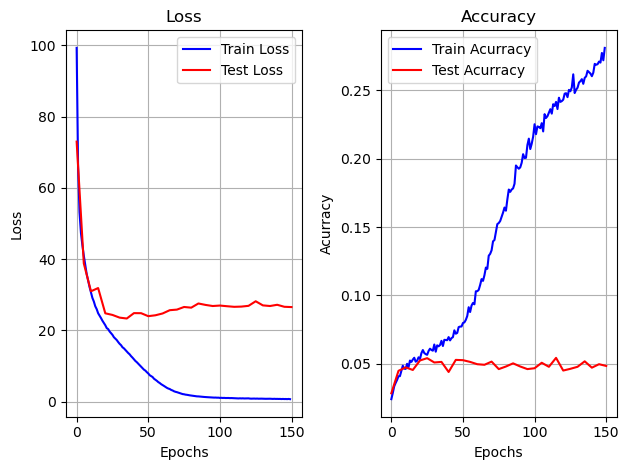

In [ ]:
np.savez('entrenamientoEdadDW.npz', a=np.array(train_loss_Edad), b=np.array(train_accuracy_Edad),c =np.array(test_loss_Edad), d = np.array(test_accuracy_Edad) )
graficaEntrenamiento(train_loss_Edad,train_accuracy_Edad,test_loss_Edad,test_accuracy_Edad,epochs=150,nombre="entrenamientoEdadDW")
torch.save(agenteDW.modeloEdad.state_dict(), './/Modelos//DWEdad3.pth')

- Raza: 30 epochs

In [ ]:
train_loss_Raza,train_accuracy_Raza,test_loss_Raza,test_accuracy_Raza = agenteDW.entrenarModelo(train_dataloader,test_dataloader,"Raza",num_epochs=30)
#25 mins

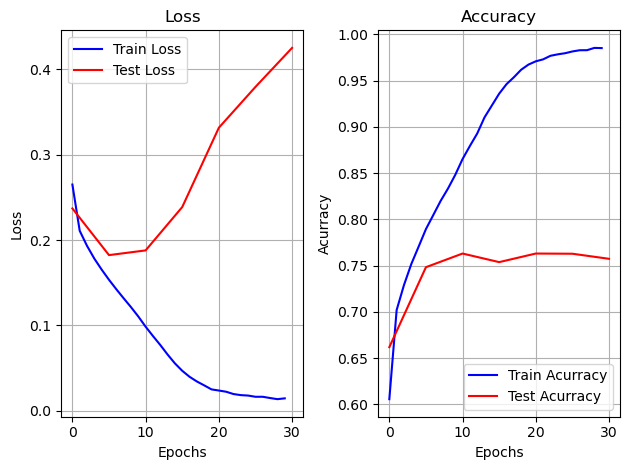

In [ ]:
np.savez('entrenamientoRazaDW.npz', a=np.array(train_loss_Raza), b=np.array(train_accuracy_Raza),c =np.array(test_loss_Raza), d = np.array(test_accuracy_Raza) )
graficaEntrenamiento(train_loss_Raza,train_accuracy_Raza,test_loss_Raza,test_accuracy_Raza,epochs=30,nombre="entrenamientoRazaDW")
#torch.save(agenteDW.modeloRaza.state_dict(), './/Modelos//DWRaza3.pth')

In [ ]:
agenteDW.modeloEdad.load_state_dict(torch.load('./Modelos/DWEdad3.pth'))
agenteDW.modeloGenero.load_state_dict(torch.load('./Modelos/DWGenero3.pth'))
agenteDW.modeloRaza.load_state_dict(torch.load('./Modelos/DWRaza3.pth'))

<All keys matched successfully>

# Resultados


In [ ]:
edadesTotal,edadesPredTotal,generosTotal,generosPredTotal,razasTotal,razasPredTotal = agenteDW.resultados(test_dataloader)

In [ ]:
metricasGenero = classification_report(generosTotal, generosPredTotal,target_names=GENERO)
metricasRaza = classification_report(razasTotal, razasPredTotal,target_names=RAZA)
print(metricasGenero)
print(metricasRaza)


              precision    recall  f1-score   support

      Hombre       0.89      0.89      0.89      2483
       Mujer       0.88      0.88      0.88      2259

    accuracy                           0.88      4742
   macro avg       0.88      0.88      0.88      4742
weighted avg       0.88      0.88      0.88      4742

              precision    recall  f1-score   support

      Blanco       0.80      0.83      0.82      1969
     Negrata       0.80      0.82      0.81       892
     Chinito       0.85      0.75      0.80       708
       Indio       0.66      0.74      0.70       835
       Otros       0.40      0.29      0.34       338

    accuracy                           0.76      4742
   macro avg       0.70      0.69      0.69      4742
weighted avg       0.76      0.76      0.76      4742



In [ ]:
print("Tasa de aciertos de la red en EDAD: ",accuracy_score(edadesTotal, edadesPredTotal)*100, "%")

Tasa de aciertos de la red en EDAD:  4.8291859974694225 %


El modelo no es capaz de determinar la edad exacta ¿ pero cuanto se equivoca? Error absoluto medio 

In [ ]:
print(f'Error absoluto medio(Edad): {mean_absolute_error(edadesTotal, edadesPredTotal)}')

Error absoluto medio(Edad): 7.564318852804724


- Matriz confusion

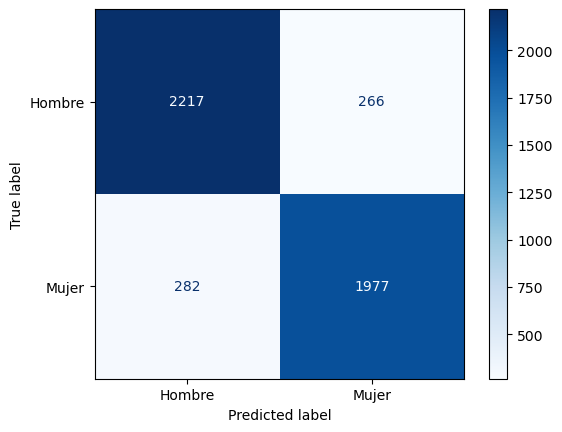

In [ ]:
matrizGenero = confusion_matrix(generosTotal, generosPredTotal)
disp = ConfusionMatrixDisplay(confusion_matrix=matrizGenero,display_labels=GENERO)
disp.plot(cmap = plt.cm.Blues)
plt.show()

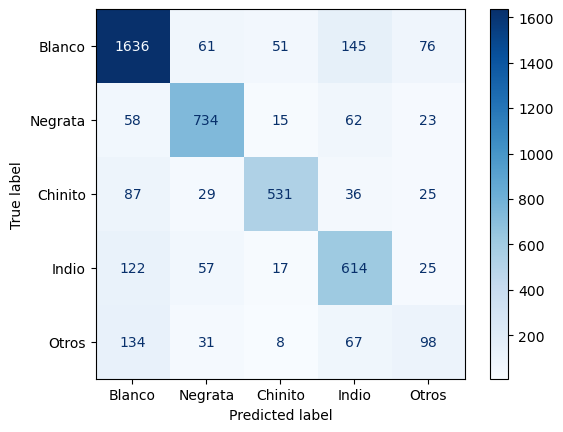

In [ ]:
matrizRaza = confusion_matrix(razasTotal, razasPredTotal)
disp = ConfusionMatrixDisplay(confusion_matrix=matrizRaza,display_labels=RAZA)
disp.plot(cmap = plt.cm.Blues)
plt.show()

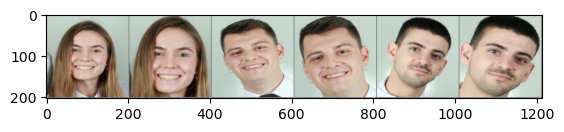

Genero Real: Mujer Mujer Hombre Hombre Hombre Hombre
Genero Pred: Mujer Mujer Hombre Hombre Hombre Hombre
Edad Real:  23.0  23.0  24.0  24.0  24.0  24.0
Edad Pred:    66    60    91    89    52    51
Raza Real: Blanco Blanco Blanco Blanco Blanco Blanco
Raza Pred: Negrata Blanco Blanco Chinito Blanco Chinito


In [ ]:

tempusFugit = data.ImgDataset("./fotos",transform=transform)
imagenes = [imagen for imagen, _, _,_ in tempusFugit ]
edades = [edad for _,edad,_,_ in tempusFugit]
generos = [genero for _,_, genero,_ in tempusFugit]
razas = [raza for _,_,_,raza in tempusFugit]

data.mostrarImg(imagenes)
imagenes = torch.stack(imagenes,dim = 0).to(device)
edades = torch.stack(edades,dim=0)
generos = torch.stack(generos,dim=0)
razas = torch.stack(razas,dim=0)

generosPred = agenteDW.modeloGenero(imagenes)
razasPred = agenteDW.modeloRaza(imagenes)
edadesPred= agenteDW.modeloEdad(imagenes)  

_, generosPred = torch.max(generosPred, 1)
_, razasPred = torch.max(razasPred, 1)


print('Genero Real:',' '.join('%5s' % GENERO[generos[j].item()] for j in range(6)))
print('Genero Pred:',' '.join('%5s' % GENERO[generosPred[j].item()] for j in range(6)))

print('Edad Real:',' '.join('%5s' % edades[j].item() for j in range(6)))
print('Edad Pred:',' '.join('%5s' % int(edadesPred[j].item()) for j in range(6)))

print('Raza Real:',' '.join('%5s' % RAZA[razas[j].item()] for j in range(6)))
print('Raza Pred:',' '.join('%5s' % RAZA[razasPred[j].item()] for j in range(6)))


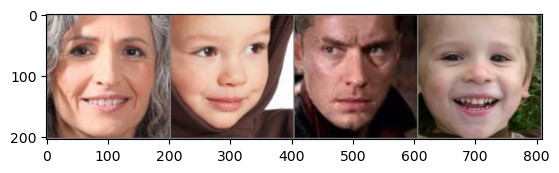

Genero Real: Mujer Hombre Hombre Hombre
Genero Pred: Mujer Hombre Hombre Mujer
Edad Real:  60.0   3.0  48.0   4.0
Edad Pred:    46     7    41     1
Raza Real: Blanco Blanco Blanco Blanco
Raza Pred: Indio Chinito Blanco Blanco


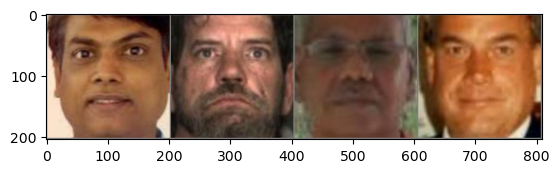

Genero Real: Hombre Hombre Hombre Hombre
Genero Pred: Hombre Hombre Hombre Hombre
Edad Real:  28.0  57.0  60.0  55.0
Edad Pred:    28    46    47    46
Raza Real: Indio Blanco Indio Blanco
Raza Pred: Indio Blanco Blanco Blanco


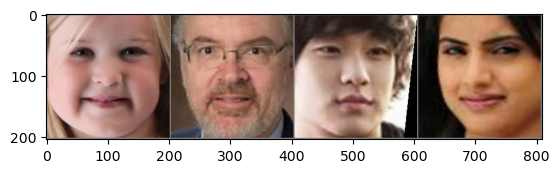

Genero Real: Mujer Hombre Hombre Mujer
Genero Pred: Mujer Hombre Hombre Mujer
Edad Real:   5.0  65.0  26.0  27.0
Edad Pred:     6    60    16    26
Raza Real: Blanco Blanco Chinito Indio
Raza Pred: Blanco Blanco Chinito Indio


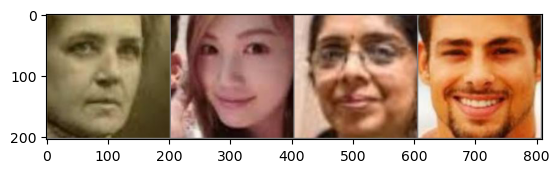

Genero Real: Mujer Mujer Mujer Hombre
Genero Pred: Mujer Mujer Mujer Hombre
Edad Real:  35.0  30.0  56.0  23.0
Edad Pred:    35    26    43    24
Raza Real: Blanco Chinito Indio Blanco
Raza Pred: Blanco Chinito Indio Otros


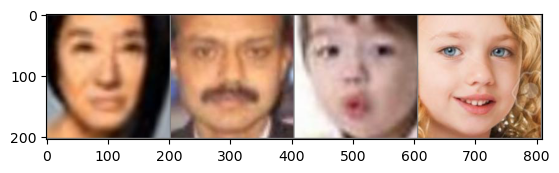

Genero Real: Mujer Hombre Hombre Mujer
Genero Pred: Mujer Hombre Mujer Mujer
Edad Real:  60.0  26.0   4.0   6.0
Edad Pred:    36    43     3     6
Raza Real: Blanco Indio Chinito Blanco
Raza Pred: Chinito Indio Chinito Blanco


In [ ]:
for batch in islice(test_dataloader,5):
    imagenes, edades,generos,razas = batch
    imagenes = imagenes.to(device)
    

    data.mostrarImg(imagenes)
    generosPred = agenteDW.modeloGenero(imagenes)
    razasPred = agenteDW.modeloRaza(imagenes)

    edadesPred= agenteDW.modeloEdad(imagenes)  

    _, generosPred = torch.max(generosPred, 1)
    _, razasPred = torch.max(razasPred, 1)


    print('Genero Real:',' '.join('%5s' % GENERO[generos[j].item()] for j in range(4)))
    print('Genero Pred:',' '.join('%5s' % GENERO[generosPred[j].item()] for j in range(4)))

    print('Edad Real:',' '.join('%5s' % edades[j].item() for j in range(4)))
    print('Edad Pred:',' '.join('%5s' % int(edadesPred[j].item()) for j in range(4)))

    print('Raza Real:',' '.join('%5s' % RAZA[razas[j].item()] for j in range(4)))
    print('Raza Pred:',' '.join('%5s' % RAZA[razasPred[j].item()] for j in range(4)))
 

    

# Modelo 2: Lola Lolita

In [ ]:
class LolaLolita(nn.Module):
    def __init__(self,output_layers):
        super().__init__()

        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=6, kernel_size=3)
        self.conv2 = nn.Conv2d(6, 12, 4)
        self.conv3 = nn.Conv2d(12,24,6)
        self.conv4 =  nn.Conv2d(24,48,16)
        self.pool2 = nn.MaxPool2d(3, 3)
       
        self.fc1 = nn.Linear(48 * 100, 1200)
        self.fc2 = nn.Linear(1200, 850)
        self.fcout = nn.Linear(850, output_layers)

        self.apply(self._init_weights)  # Aplicar la inicialización de pesos

    def _init_weights(self, m):
        """Inicializa los pesos de la red"""
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            init.normal_(m.weight, mean=0.0, std=0.02)
            if m.bias is not None:
                init.constant_(m.bias, 0)

    def forward(self, x):

        x = self.pool1(x) 
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(F.relu(self.conv3(x)))
        x = self.pool2(F.relu(self.conv4(x)))
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fcout(x)
        return x

In [ ]:
#Esto sirve para ver en que dispositivo se entrena.
#GPU(cuda) es mas rapido que CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Entrenando en: {device}")

Entrenando en: cuda


In [ ]:
#Modelo edad
LLEdad = LolaLolita(output_layers=1).to(device)
mseLoss = nn.MSELoss()

#Modelo Genero
LLGenero = LolaLolita(output_layers=2).to(device)
entropyLossGen = nn.CrossEntropyLoss()

#Modelo raza
LLRaza = LolaLolita(output_layers=5).to(device)
entropyLossRaza = nn.CrossEntropyLoss()

agenteLL= agente.Agente(modeloEdad=LLEdad,
                         modeloGenero=LLGenero,
                         modeloRaza=LLRaza,
                         criterioEdad=mseLoss,
                         criterioGenero=entropyLossGen,
                         criterioRaza=entropyLossRaza,
                         device=device,
                         lr = 0.00001)

- Genero: 30 epochs

In [ ]:
train_loss_Genero,train_accuracy_Genero,test_loss_Genero,test_accuracy_Genero = agenteLL.entrenarModelo(train_dataloader,test_dataloader,"Genero",num_epochs=30)
torch.save(agenteLL.modeloGenero.state_dict(), './/Modelos//LLGenero.pth')
np.savez('entrenamientoGeneroLL.npz', a=np.array(train_loss_Genero), b=np.array(train_accuracy_Genero),c =np.array(test_loss_Genero), d = np.array(test_accuracy_Genero) )

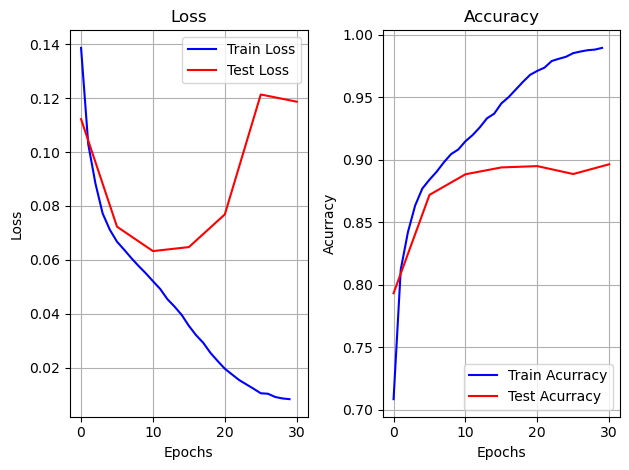

In [ ]:
graficaEntrenamiento(train_loss_Genero,train_accuracy_Genero,test_loss_Genero,test_accuracy_Genero,epochs=30,nombre="entrenamientoGeneroLL")

- Edad: 100 epochs

In [ ]:
train_loss_Edad,train_accuracy_Edad,test_loss_Edad,test_accuracy_Edad = agenteLL.entrenarModelo(train_dataloader,test_dataloader,"Edad",num_epochs=100)
torch.save(agenteLL.modeloEdad.state_dict(), './/Modelos//LLGenero.pth')
np.savez('entrenamientoEdadLL.npz', a=np.array(train_loss_Edad), b=np.array(train_accuracy_Edad),c =np.array(test_loss_Edad), d = np.array(test_accuracy_Edad) )

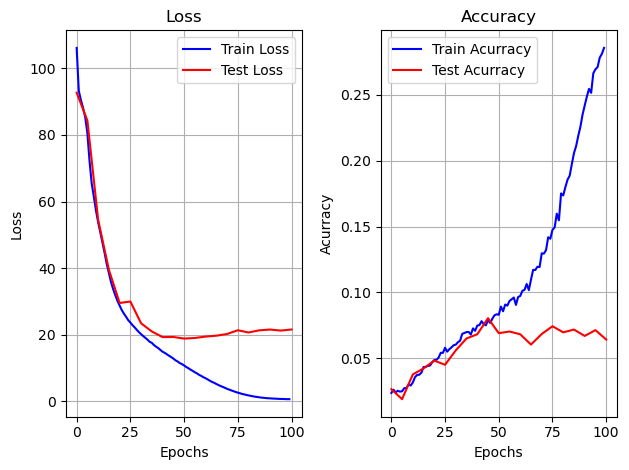

In [ ]:
graficaEntrenamiento(train_loss_Edad,train_accuracy_Edad,test_loss_Edad,test_accuracy_Edad,epochs=100,nombre="entrenamientoEdadLL")

- Raza: 30 epochs

In [ ]:
train_loss_Raza,train_accuracy_Raza,test_loss_Raza,test_accuracy_Raza = agenteLL.entrenarModelo(train_dataloader,test_dataloader,"Raza",num_epochs=30)
graficaEntrenamiento(train_loss_Raza,train_accuracy_Raza,test_loss_Raza,test_accuracy_Raza,epochs=(30),nombre="entrenamientoRazaLL")

torch.save(agenteLL.modeloRaza.state_dict(), './/Modelos//LLRaza.pth')
np.savez('entrenamientoRazaLL.npz', a=np.array(train_loss_Raza), b=np.array(train_accuracy_Raza),c =np.array(test_loss_Raza), d = np.array(test_accuracy_Raza) )

In [ ]:
agenteLL.modeloEdad.load_state_dict(torch.load('./Modelos/LLEdad.pth'))
agenteLL.modeloGenero.load_state_dict(torch.load('./Modelos/LLGenero.pth'))
agenteLL.modeloRaza.load_state_dict(torch.load('./Modelos/LLRaza.pth'))

<All keys matched successfully>

# Resultados

In [ ]:
edades,edadesPred,generos,generosPred,razas,razasPred = agenteLL.resultados(test_dataloader)

In [ ]:
accuracy_score(generos,generosPred)

0.8966680725432307

In [ ]:
metricasGenero = classification_report(generos, generosPred,target_names=GENERO)
metricasRaza = classification_report(razas, razasPred,target_names=RAZA)
print(metricasGenero)
print(metricasRaza)

              precision    recall  f1-score   support

      Hombre       0.92      0.88      0.90      2483
       Mujer       0.87      0.92      0.89      2259

    accuracy                           0.90      4742
   macro avg       0.90      0.90      0.90      4742
weighted avg       0.90      0.90      0.90      4742

              precision    recall  f1-score   support

      Blanco       0.40      0.08      0.14      1969
     Negrata       0.08      0.02      0.03       892
     Chinito       0.14      0.69      0.23       708
       Indio       0.18      0.04      0.06       835
       Otros       0.06      0.08      0.07       338

    accuracy                           0.15      4742
   macro avg       0.17      0.18      0.11      4742
weighted avg       0.24      0.15      0.12      4742



In [ ]:
print("Tasa de aciertos de la red en EDAD: ",accuracy_score(edades, edadesPred)*100, "%")
print(f'Error absoluto medio(Edad): {mean_absolute_error(edades, edadesPred)}')

Tasa de aciertos de la red en EDAD:  7.001265288907634 %
Error absoluto medio(Edad): 6.655208772669759


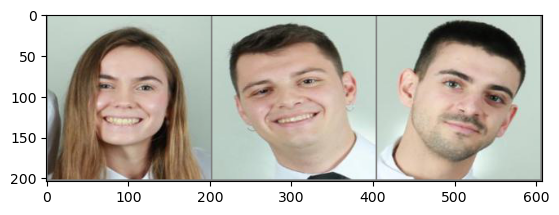

Genero Real: Mujer Hombre Hombre
Genero Pred: Mujer Mujer Mujer
Edad Real:  23.0  24.0  24.0
Edad Pred:    18    49    29
Raza Real: Blanco Blanco Blanco
Raza Pred: Chinito Chinito Otros


In [ ]:
tempusFugit = data.ImgDataset("./fotos",transform=transform)
imagenes = [imagen for imagen, _, _,_ in tempusFugit ]
edades = [edad for _,edad,_,_ in tempusFugit]
generos = [genero for _,_, genero,_ in tempusFugit]
razas = [raza for _,_,_,raza in tempusFugit]

data.mostrarImg(imagenes)
imagenes = torch.stack(imagenes,dim = 0).to(device)
edades = torch.stack(edades,dim=0)
generos = torch.stack(generos,dim=0)
razas = torch.stack(razas,dim=0)
with torch.no_grad():   
    generosPred = agenteLL.modeloGenero(imagenes)
    razasPred = agenteLL.modeloRaza(imagenes)
    edadesPred= agenteLL.modeloEdad(imagenes)  

    _, generosPred = torch.max(generosPred, 1)
    _, razasPred = torch.max(razasPred, 1)


print('Genero Real:',' '.join('%5s' % GENERO[generos[j].item()] for j in range(3)))
print('Genero Pred:',' '.join('%5s' % GENERO[generosPred[j].item()] for j in range(3)))

print('Edad Real:',' '.join('%5s' % edades[j].item() for j in range(3)))
print('Edad Pred:',' '.join('%5s' % int(edadesPred[j].item()) for j in range(3)))

print('Raza Real:',' '.join('%5s' % RAZA[razas[j].item()] for j in range(3)))
print('Raza Pred:',' '.join('%5s' % RAZA[razasPred[j].item()] for j in range(3)))

In [ ]:
#Este codigo es solo de prueba
train_loss,train_accuracy,test_loss,test_accuracy = agenteLL.entrenarModelo(train_dataloader,test_dataloader,"Edad",num_epochs=5)
graficaEntrenamiento(train_loss,train_accuracy,test_loss,test_accuracy,epochs=(5),nombre="entrenamientoEdadLL")

for i in range(19):
    run_train_loss,run_train_accuracy,run_test_loss,run_test_accuracy = agenteLL.entrenarModelo(train_dataloader,test_dataloader,"Edad",num_epochs=5)
    
    train_loss += run_train_loss
    train_accuracy +=run_train_accuracy
    test_loss +=run_test_loss[1:]
    test_accuracy +=run_test_accuracy[1:]

    graficaEntrenamiento(train_loss,train_accuracy,test_loss,test_accuracy,epochs=(5*(i+2)),nombre="entrenamientoEdadLL")
    torch.save(agenteLL.modeloEdad.state_dict(), './/Modelos//LLEdad2.pth')
    np.savez('entrenamientoEdadLL.npz', a=np.array(train_loss), b=np.array(train_accuracy),c =np.array(test_loss), d = np.array(test_accuracy) )

# Modelo 3: Rubiales

In [33]:

importlib.reload(agente_knn)

<module 'agente_knn' from 'c:\\Users\\Itziar\\Documents\\Documentos\\PAD\\Aprendizaje-Automatico-y-Big-Data\\Practica5\\agente_knn.py'>

In [4]:


# Adaptamos las imagenes a un dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = agente_knn.ImgDatasetAux(path, transform=transform)  # Pasamos las imagenes a la estructura de datos

# Seleccionar aleatoriamente 15000 imágenes para entrenamiento
subset_size = 15000
indices = np.random.choice(len(dataset), subset_size, replace=False)
subset_dataset = Subset(dataset, indices)

# Crear los DataLoaders a partir del subconjunto de datos
train_dataloader, test_dataloader = data.entrenamientoTest(dataset=subset_dataset, test_size=0.2, batch_size=4)

# Ver el número de lotes (batches) que contiene cada DataLoader
print(len(train_dataloader))  # Número de batches de entrenamiento
print(len(test_dataloader))   # Número de batches de prueba
GENERO = ('Hombre','Mujer')
RAZA = ('Blanco','Negro','Asiático','Indio','Otros')


3000
750


### Modelo raza

k=1 -> Puntuación media de la validación cruzada: 0.44000000000000006
k=2 -> Puntuación media de la validación cruzada: 0.4575
k=3 -> Puntuación media de la validación cruzada: 0.4575
k=4 -> Puntuación media de la validación cruzada: 0.46499999999999997
k=5 -> Puntuación media de la validación cruzada: 0.48
k=6 -> Puntuación media de la validación cruzada: 0.4875
k=7 -> Puntuación media de la validación cruzada: 0.5
k=8 -> Puntuación media de la validación cruzada: 0.49749999999999994
k=9 -> Puntuación media de la validación cruzada: 0.49000000000000005
k=10 -> Puntuación media de la validación cruzada: 0.49749999999999994
k=11 -> Puntuación media de la validación cruzada: 0.5025000000000001
k=12 -> Puntuación media de la validación cruzada: 0.495
k=13 -> Puntuación media de la validación cruzada: 0.5125
k=14 -> Puntuación media de la validación cruzada: 0.49499999999999994
k=15 -> Puntuación media de la validación cruzada: 0.5025
k=16 -> Puntuación media de la validación cruzada: 0.49

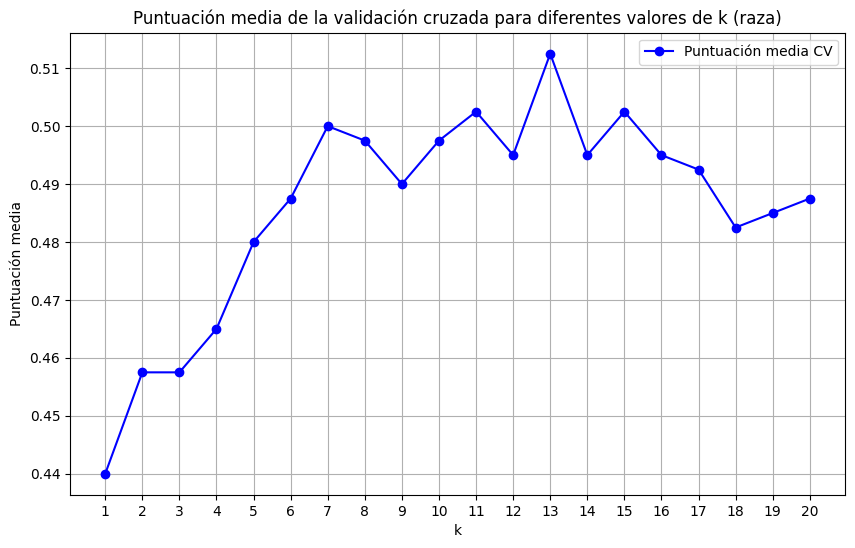

(13, np.float64(0.5125))

In [45]:
agente_knn.encontrar_mejor_k(train_dataloader, categoria= 'raza',num_imagenes=100, k_range=range(1, 21))

In [ ]:

modelo_knn_raza = agente_knn.entrenar_knn(train_dataloader, n_neighbors=13, etiqueta="raza")
data.guardar_modelo(modelo_knn_raza,"entrenamientoRazaModelo3")

Modelo guardado en entrenamientoRazaModelo3


In [5]:
modelo_knn_raza = data.recuperar_modelo("entrenamientoRazaModelo3")

Modelo cargado desde entrenamientoRazaModelo3


In [34]:
razasTotal, razasPredTotal = agente_knn.evaluar_modelo(modelo_knn_raza,test_dataloader,etiqueta= 'raza')

Precisión (accuracy) en el conjunto de prueba: 0.5190
Error cuadrático medio (RMSE) en el conjunto de prueba: 1.7002

Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.4931    0.9103    0.6397      1215
           1     0.6877    0.4169    0.5191       602
           2     0.6400    0.1728    0.2721       463
           3     0.4500    0.2317    0.3059       505
           4     0.4286    0.0140    0.0270       215

    accuracy                         0.5190      3000
   macro avg     0.5399    0.3491    0.3528      3000
weighted avg     0.5429    0.5190    0.4587      3000



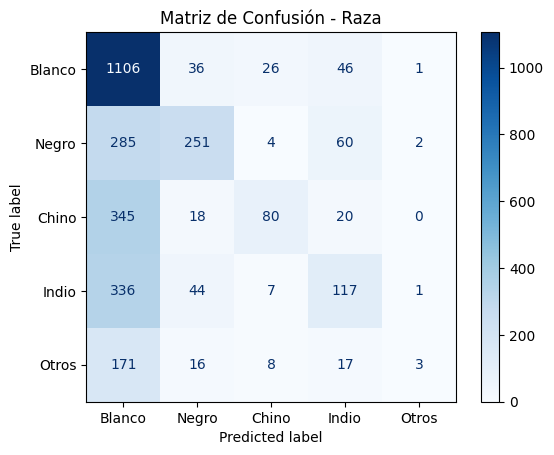

In [35]:
matrizRaza = confusion_matrix(razasTotal, razasPredTotal)
disp = ConfusionMatrixDisplay(confusion_matrix=matrizRaza, display_labels=RAZA)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión - Raza")
plt.show()

### Modelo edad

c:\Users\Itziar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


k=1 -> Puntuación media de la validación cruzada: 0.2575


c:\Users\Itziar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


k=2 -> Puntuación media de la validación cruzada: 0.23500000000000001


c:\Users\Itziar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


k=3 -> Puntuación media de la validación cruzada: 0.2375


c:\Users\Itziar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


k=4 -> Puntuación media de la validación cruzada: 0.22750000000000004


c:\Users\Itziar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


k=5 -> Puntuación media de la validación cruzada: 0.25


c:\Users\Itziar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


k=6 -> Puntuación media de la validación cruzada: 0.26999999999999996


c:\Users\Itziar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


k=7 -> Puntuación media de la validación cruzada: 0.265


c:\Users\Itziar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


k=8 -> Puntuación media de la validación cruzada: 0.2725


c:\Users\Itziar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


k=9 -> Puntuación media de la validación cruzada: 0.26


c:\Users\Itziar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


k=10 -> Puntuación media de la validación cruzada: 0.28250000000000003


c:\Users\Itziar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


k=11 -> Puntuación media de la validación cruzada: 0.3025


c:\Users\Itziar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


k=12 -> Puntuación media de la validación cruzada: 0.3


c:\Users\Itziar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


k=13 -> Puntuación media de la validación cruzada: 0.2925


c:\Users\Itziar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


k=14 -> Puntuación media de la validación cruzada: 0.2925


c:\Users\Itziar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


k=15 -> Puntuación media de la validación cruzada: 0.2925


c:\Users\Itziar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


k=16 -> Puntuación media de la validación cruzada: 0.305


c:\Users\Itziar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


k=17 -> Puntuación media de la validación cruzada: 0.32499999999999996


c:\Users\Itziar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


k=18 -> Puntuación media de la validación cruzada: 0.33999999999999997


c:\Users\Itziar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


k=19 -> Puntuación media de la validación cruzada: 0.34249999999999997


c:\Users\Itziar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


k=20 -> Puntuación media de la validación cruzada: 0.32749999999999996

El valor óptimo de k es: 19 con una puntuación media de: 0.34249999999999997


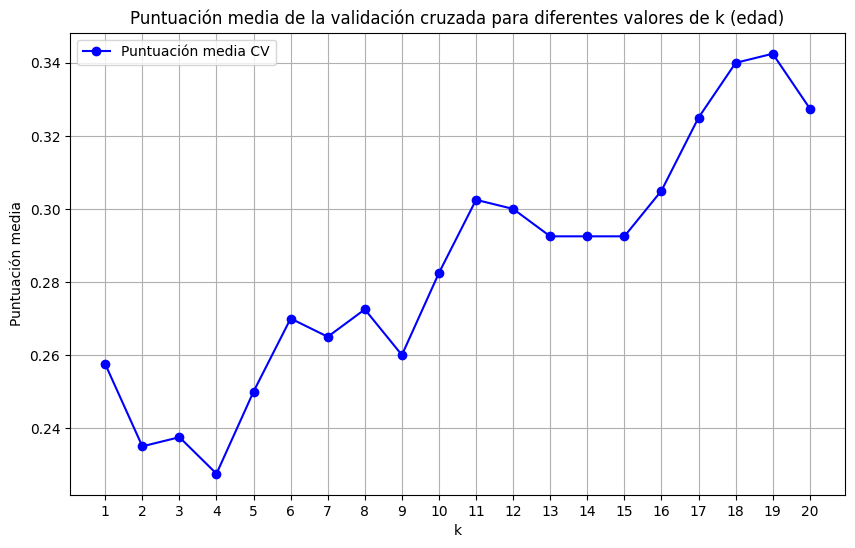

(19, np.float64(0.34249999999999997))

In [ ]:
agente_knn.encontrar_mejor_k(train_dataloader, categoria= 'edad',num_imagenes=100, k_range=range(1, 21))

In [ ]:
modelo_knn_edad = data.entrenar_knn_completo(train_dataloader,n_neighbors=19, etiqueta="edad")
data.guardar_modelo(modelo_knn_edad,"entrenamientoEdadModelo3")

Modelo guardado en entrenamientoEdadModelo3


In [6]:
modelo_knn_edad = data.recuperar_modelo("entrenamientoEdadModelo3")

Error al cargar el modelo desde entrenamientoEdadModelo3: Unable to allocate 3.58 GiB for an array with shape (960000000,) and data type float32


In [37]:
edadesTotal, edadesPredTotal = agente_knn.evaluar_modelo(modelo_knn_edad,test_dataloader,etiqueta= 'edad')

Precisión (accuracy) en el conjunto de prueba: 0.1700
Error cuadrático medio (RMSE) en el conjunto de prueba: 1.8938

Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       405
           1     0.0639    0.1608    0.0914       199
           2     0.1791    0.0128    0.0239       938
           3     0.2264    0.5802    0.3257       586
           4     0.1282    0.2247    0.1632       316
           5     0.1698    0.0677    0.0968       266
           6     0.1300    0.2132    0.1616       136
           7     0.1795    0.0854    0.1157        82
           8     0.1429    0.0192    0.0339        52
           9     0.0000    0.0000    0.0000        20

    accuracy                         0.1700      3000
   macro avg     0.1220    0.1364    0.1012      3000
weighted avg     0.1463    0.1700    0.1140      3000



c:\Users\Itziar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Itziar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Itziar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

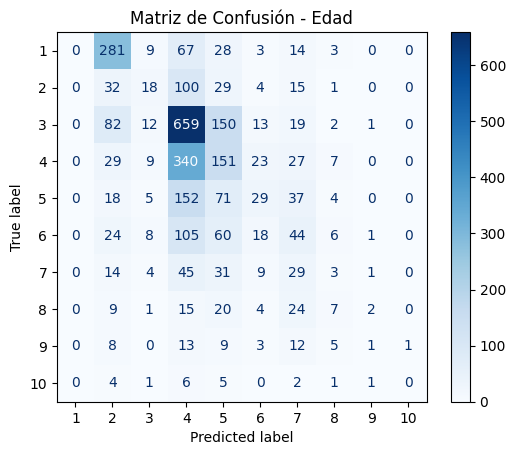

In [40]:
matrizEdad = confusion_matrix(edadesTotal, edadesPredTotal)
disp = ConfusionMatrixDisplay(confusion_matrix=matrizEdad,display_labels = ['1','2','3', '4','5','6','7','8','9','10'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión - Edad")
plt.show()

### Modelo género

k=1 -> Puntuación media de la validación cruzada: 0.65
k=2 -> Puntuación media de la validación cruzada: 0.6416666666666666
k=3 -> Puntuación media de la validación cruzada: 0.665
k=4 -> Puntuación media de la validación cruzada: 0.6483333333333332
k=5 -> Puntuación media de la validación cruzada: 0.6799999999999999
k=6 -> Puntuación media de la validación cruzada: 0.6566666666666666
k=7 -> Puntuación media de la validación cruzada: 0.6683333333333333
k=8 -> Puntuación media de la validación cruzada: 0.6566666666666666
k=9 -> Puntuación media de la validación cruzada: 0.675
k=10 -> Puntuación media de la validación cruzada: 0.655
k=11 -> Puntuación media de la validación cruzada: 0.6699999999999999
k=12 -> Puntuación media de la validación cruzada: 0.6566666666666666
k=13 -> Puntuación media de la validación cruzada: 0.68
k=14 -> Puntuación media de la validación cruzada: 0.675
k=15 -> Puntuación media de la validación cruzada: 0.6683333333333334
k=16 -> Puntuación media de la validaci

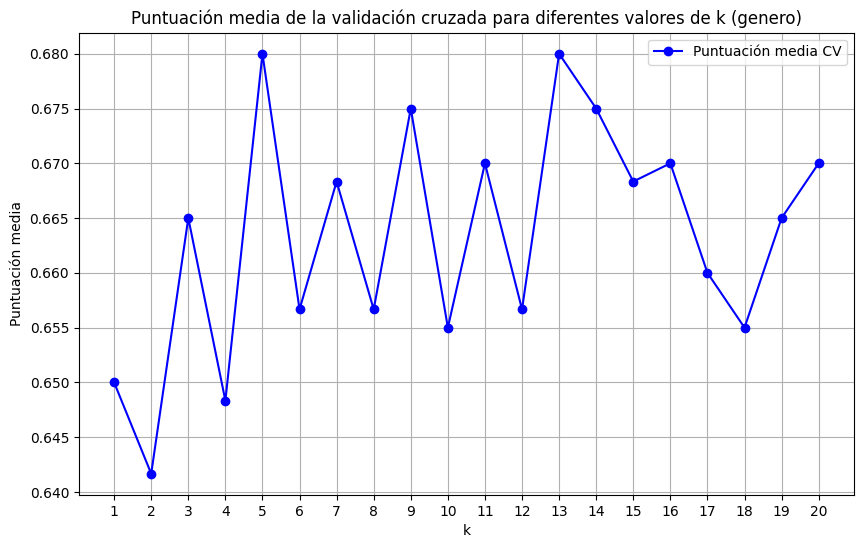

(13, np.float64(0.68))

In [ ]:
data.encontrar_mejor_k(train_dataloader, categoria= 'genero',num_imagenes=150, k_range=range(1, 21))

In [ ]:
modelo_knn_genero = data.entrenar_knn_completo(train_dataloader, n_neighbors=13, etiqueta="genero")
data.guardar_modelo(modelo_knn_genero,"entrenamientoGeneroModelo3")

Modelo guardado en entrenamientoGeneroModelo3


In [41]:
modelo_knn_genero = data.recuperar_modelo("entrenamientoGeneroModelo3")

Modelo cargado desde entrenamientoGeneroModelo3


In [ ]:
generoTotal, generoPredTotal = agente_knn.evaluar_modelo(modelo_knn_genero,test_dataloader,etiqueta= 'genero')

Precisión (accuracy) en el conjunto de prueba: 0.7347
Error cuadrático medio (RMSE) en el conjunto de prueba: 0.5151

Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.7255    0.7981    0.7601      1580
           1     0.7472    0.6641    0.7032      1420

    accuracy                         0.7347      3000
   macro avg     0.7364    0.7311    0.7317      3000
weighted avg     0.7358    0.7347    0.7332      3000



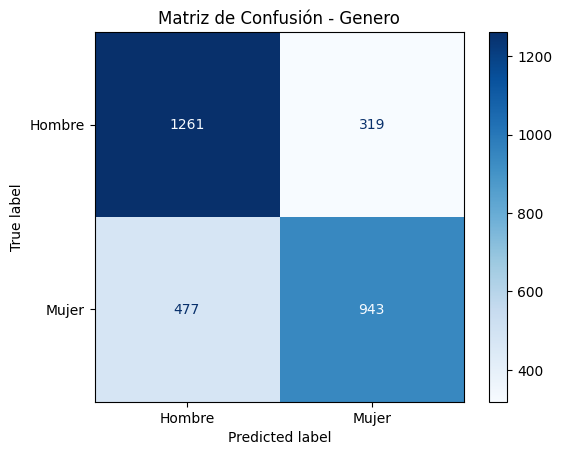

In [47]:
matrizGenero = confusion_matrix(generoTotal, generoPredTotal)
disp = ConfusionMatrixDisplay(confusion_matrix=matrizGenero,display_labels = GENERO)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión - Genero")
plt.show()

# Modelo 4: Napoleón

In [48]:
importlib.reload(agente_mlp)

<module 'agente_mlp' from 'c:\\Users\\Itziar\\Documents\\Documentos\\PAD\\Aprendizaje-Automatico-y-Big-Data\\Practica5\\agente_mlp.py'>

In [49]:
# Transformación que redimensiona las imágenes y las normaliza
transform = transforms.Compose([ 
    transforms.Resize((64, 64)),             # Redimensiona las imágenes a 64x64
    transforms.ToTensor(),                   # Convierte las imágenes a tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normaliza las imágenes
])

dataset = agente_knn.ImgDatasetAux(path,transform=transform) #Pasamos las imagenes a la estructura de datos

GENERO = ('Hombre','Mujer')
RAZA = ('Blanco','Negro','Chino','Indio','Otros')

In [50]:
# Crear los DataLoaders
train_dataloader,test_dataloader = data.entrenamientoTest(dataset=dataset,test_size=0.2,batch_size=4)

In [8]:
class MLP(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLP, self).__init__()
        # Definir las capas del MLP
        self.fc1 = nn.Linear(input_size, 512)  # Capa de entrada -> 512 unidades
        self.fc2 = nn.Linear(512, 256)         # Capa oculta -> 256 unidades
        self.fc3 = nn.Linear(256, num_classes) # Capa de salida -> número de clases

    def forward(self, x):
        # Aplanar las imágenes de tamaño (batch_size, 3, 64, 64) a (batch_size, 12288)
        x = x.view(x.size(0), -1)  # Aplanar las imágenes a un vector 1D por imagen
        x = F.relu(self.fc1(x))    # Capa 1 -> ReLU
        x = F.relu(self.fc2(x))    # Capa 2 -> ReLU
        x = self.fc3(x)            # Capa 3 -> Salida
        return x


## Modelo para la raza

In [ ]:
mlp_raza = MLP(input_size=64*64*3, num_classes=5)
# Entrenar y evaluar al mismo tiempo
train_losses, train_accuracies, test_losses, test_accuracies = agente_mlp.train_and_evaluate(mlp_raza, train_dataloader, test_dataloader, etiqueta='raza', num_epochs=20)
torch.save(mlp_raza.state_dict(), 'entrenamientoRazaModelo4.pth')

In [51]:

mlp_raza = MLP(input_size=64*64*3, num_classes=5)
mlp_raza.load_state_dict(torch.load('entrenamientoRazaModelo4.pth'))


<All keys matched successfully>

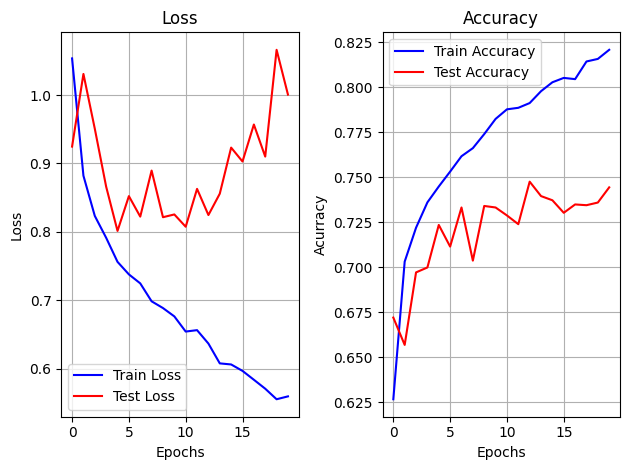

In [14]:
graficaEntrenamiento(train_losses,train_accuracies,test_losses,test_accuracies,epochs=20,nombre="entrenamientoRaza")

In [53]:
razaTotal, razaPredTotal = agente_mlp.evaluar_mlp(mlp_raza, test_dataloader,etiqueta='raza')

Precisión (accuracy): 0.7290
RMSE: 1.2862
Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.8052    0.7664    0.7853      1969
           1     0.7319    0.8599    0.7907       892
           2     0.6909    0.7387    0.7140       708
           3     0.6894    0.7018    0.6955       835
           4     0.3380    0.2130    0.2613       338

    accuracy                         0.7290      4742
   macro avg     0.6511    0.6560    0.6494      4742
weighted avg     0.7207    0.7290    0.7225      4742



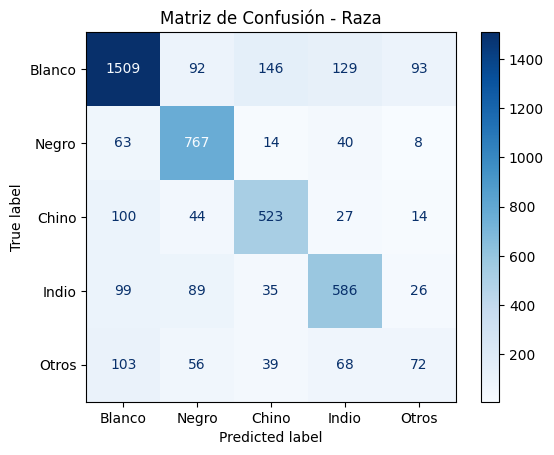

In [54]:
matrizRaza = confusion_matrix(razaTotal, razaPredTotal)
disp = ConfusionMatrixDisplay(confusion_matrix=matrizRaza,display_labels = RAZA)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión - Raza")
plt.show()

## Modelo para el género

In [ ]:
model = MLP(input_size=64*64*3, num_classes=2)
# Entrenar y evaluar al mismo tiempo
train_losses, train_accuracies, test_losses, test_accuracies = train_and_evaluate(model, train_dataloader, test_dataloader, etiqueta='genero', num_epochs=20)
torch.save(model.state_dict(), 'entrenamientoGeneroModelo4.pth')
graficaEntrenamiento(train_losses,train_accuracies,test_losses,test_accuracies,epochs=20,nombre="entrenamientoGenero")


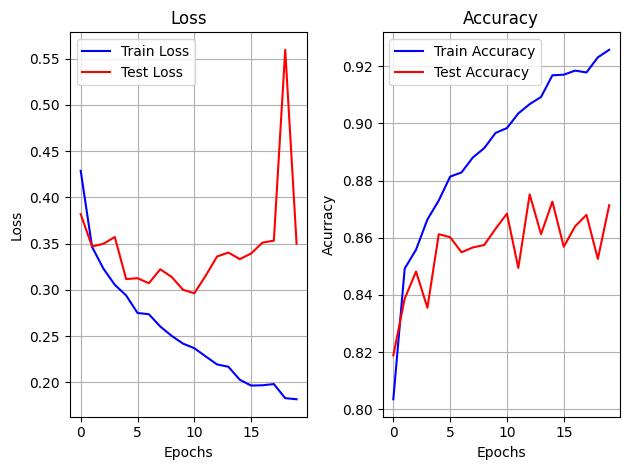

In [41]:
graficaEntrenamiento(train_losses,train_accuracies,test_losses,test_accuracies,epochs=20,nombre="entrenamientoGenero")

In [19]:
mlp_genero = MLP(input_size=64*64*3, num_classes=2)
mlp_genero.load_state_dict(torch.load('entrenamientoGeneroModelo4.pth'))

<All keys matched successfully>

In [ ]:
generoTotal, generoPredTotal = agente_mlp.evaluar_mlp(mlp_, test_dataloader,etiqueta='genero')

Precisión (accuracy): 0.8714
RMSE: 0.3587
Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.8651    0.8937    0.8792      2483
           1     0.8787    0.8468    0.8625      2259

    accuracy                         0.8714      4742
   macro avg     0.8719    0.8703    0.8708      4742
weighted avg     0.8716    0.8714    0.8712      4742



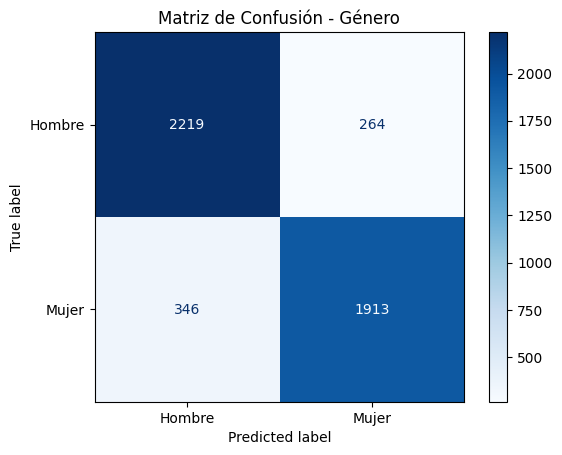

In [56]:
matrizGenero = confusion_matrix(generoTotal, generoPredTotal)
disp = ConfusionMatrixDisplay(confusion_matrix=matrizGenero,display_labels = GENERO)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión - Género")
plt.show()

## Modelo para la edad

In [42]:
model = MLP(input_size=3*64*64, num_classes=10)
train_losses, train_accuracies, test_losses, test_accuracies = train_and_evaluate(model, train_dataloader, test_dataloader, etiqueta='edad', num_epochs=20)
torch.save(model.state_dict(), 'entrenamientoEdadModelo4.pth')

In [21]:
mlp_edad = MLP(input_size=64*64*3, num_classes=10)
mlp_edad.load_state_dict(torch.load('entrenamientoEdadModelo4.pth'))

<All keys matched successfully>

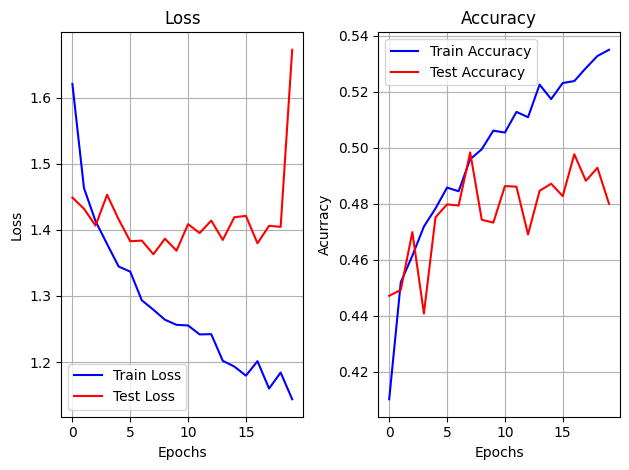

In [18]:
graficaEntrenamiento(train_losses,train_accuracies,test_losses,test_accuracies,epochs=20,nombre="entrenamientoEdad")

In [57]:
edadTotal, edadPredTotal = agente_mlp.evaluar_mlp(mlp_edad, test_dataloader,etiqueta='edad')

Precisión (accuracy): 0.4831
RMSE: 1.3669
Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.8428    0.8120    0.8271       601
           1     0.5152    0.2993    0.3786       284
           2     0.5655    0.7562    0.6471      1501
           3     0.3371    0.2038    0.2540       888
           4     0.2609    0.3734    0.3071       466
           5     0.3342    0.2739    0.3011       471
           6     0.2848    0.1808    0.2212       260
           7     0.0000    0.0000    0.0000       137
           8     0.2165    0.4950    0.3012       101
           9     0.5000    0.0606    0.1081        33

    accuracy                         0.4831      4742
   macro avg     0.3857    0.3455    0.3346      4742
weighted avg     0.4623    0.4831    0.4593      4742



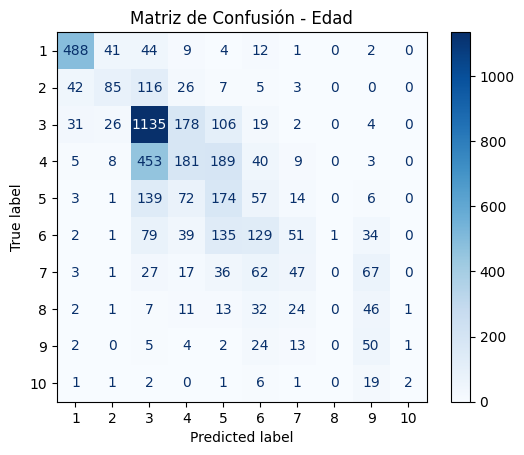

In [58]:
matrizEdad = confusion_matrix(edadTotal, edadPredTotal)
disp = ConfusionMatrixDisplay(confusion_matrix=matrizEdad,display_labels = ['1','2','3', '4','5','6','7','8','9','10'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión - Edad")
plt.show()